# Training a Diffusion Model

*Author: Bardia Khosravi, MD*

Diffusion models are a group of Generative AI models that excell at image generation. They have a remarkable capability for being conditioned on many criteria. In this notebook, we will train a simple diffusion model using the [Kermany et al.](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810) dataset and the [MONAI](https://monai.io) and [Mediffusion](https://github.com/BardiaKh/Mediffusion) packages to create synthetic chest radiographs with certain pathologies.

Before starting, we need to install the `Mediffusion` (model training) and `wandb` (logging) packages:

In [ ]:
!pip install mediffusion wandb -U

Then we import our packages:

In [ ]:
import gdown
import os
import zipfile
from glob import glob
from tqdm.auto import tqdm
import monai as mn
import bkh_pytorch_utils as bpu
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import yaml
from mediffusion import DiffusionModule, Trainer

In the next cell, we will download the dataset needed to train the model.

In [ ]:
if not os.path.isdir("workshop_data"):
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1r_lLkw8JQR2EUCPI6TLqsq5S_mV2SOQU",
        "workshop_data.zip",
        quiet=False,
    )
    os.mkdir("workshop_data")

    with zipfile.ZipFile("workshop_data.zip", 'r') as zip_ref:
        zip_ref.extractall("workshop_data")

    os.remove("workshop_data.zip")

    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1L_gKWO87A4qCL1H95yfMA3TmEwXjhtr8",
        "ddpm_weights.zip",
        quiet=False,
    )
    with zipfile.ZipFile("ddpm_weights.zip", 'r') as zip_ref:
        zip_ref.extractall("workshop_data")

    os.remove("ddpm_weights.zip")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1r_lLkw8JQR2EUCPI6TLqsq5S_mV2SOQU
To: /content/workshop_data.zip
100%|██████████| 1.23G/1.23G [00:15<00:00, 81.4MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1L_gKWO87A4qCL1H95yfMA3TmEwXjhtr8
To: /content/ddpm_weights.zip
100%|██████████| 371M/371M [00:03<00:00, 111MB/s] 


First, let's define some constants:

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"                          # set your GPU devices
os.environ['WANDB_API_KEY'] = "YOUR_WANDB_API_KEY"
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'     # handling error on some devices for wandb logging

TOTAL_IMAGE_SEEN = 1e7
BATCH_SIZE = 4
NUM_DEVICES = 1
TRAIN_ITERATIONS = int(TOTAL_IMAGE_SEEN / (BATCH_SIZE * NUM_DEVICES))

We use [wandb](https://wandb.ai) for logging purposes. You need to enter you `WANDB_API_KEY` so that you can see the training progress and log the results in your dashboard. You can find your api key [here](https://app.wandb.ai/authorize). Additionally, we set `TOTAL_IMAGE_SEEN` to `1e7`. This means that during the training process, we want the model to see 10 million images. However, please note that this is not unique images and the set is sampled with replacement from the original 5000 images, i.e., each image is roughly seen by the model 2000 times.

As we want to use MONAI, we want to create a list of dictionaries in which each item, represents an image and its corresponding label.

In [ ]:
files = glob(f"./workshop_data/chest_xray/*/*/*.jpeg")
data_dictionary = []
for file in tqdm(files):
    label = file.split("/")[-2]
    if label == "NORMAL":
        cls_label = 0
    else:
        if "virus" in file:
            cls_label = 1
        else:
            cls_label = 2
    data_dictionary.append({"img": file, "cls": cls_label})

  0%|          | 0/5856 [00:00<?, ?it/s]

In [ ]:
data_dictionary[:2]

[{'img': './workshop_data/chest_xray/train/NORMAL/NORMAL2-IM-0772-0001.jpeg',
  'cls': 0},
 {'img': './workshop_data/chest_xray/train/NORMAL/IM-0656-0001-0002.jpeg',
  'cls': 0}]

We will use the last 100 images for validation and the rest will be for training the model.

In [ ]:
train_data = data_dictionary[:-100]
val_data = data_dictionary[-100:]

Next we use MONAI transforms and `PersistentDataset` to create our training and validation datasets.

In [ ]:
transforms = mn.transforms.Compose([
    mn.transforms.LoadImageD(keys="img"),
    bpu.EnsureGrayscaleD(keys="img"),
    mn.transforms.ResizeD(keys='img', size_mode="longest", mode="bilinear", spatial_size=256, align_corners=False),
    mn.transforms.ScaleIntensityRangePercentilesD(keys="img", lower=0, upper=100, b_min=-1, b_max=1, clip=True),
    mn.transforms.SpatialPadD(keys='img', spatial_size=(256, 256), mode="constant", constant_values=-1),
    mn.transforms.ToTensorD(keys=["cls"], dtype=torch.float),
    mn.transforms.AsDiscreteD(keys=["cls"], to_onehot=[3]),
    mn.transforms.SelectItemsD(keys=["img","cls"]),
    mn.transforms.ToTensorD(keys=["img","cls"], dtype=torch.float, track_meta=False),
])

train_ds = mn.data.PersistentDataset(data=train_data, transform=transforms, cache_dir="./cache/train")
valid_ds = mn.data.PersistentDataset(data=val_data, transform=transforms, cache_dir="./cache/val")

Lets's visualize a sample:

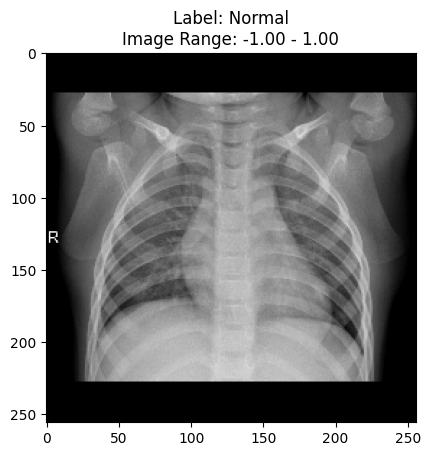

In [ ]:
def visualize_sample(item):
    label_dict = {0: "Normal", 1: "Viral Pneumonia", 2: "Bacterial Pneumonia"}
    img = item["img"].permute(2, 1, 0)
    cls_label = label_dict[item["cls"].argmax(dim=0).item()]
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {cls_label}\nImage Range: {img.min().item():.2f} - {img.max().item():.2f}")
    plt.show()

visualize_sample(train_ds[5])

Now, each item of the dataset has an `img` key (image tensore resized to 256x256 and scaled between [-1,1]) and a `cls` key (one-hot encoded class label).

We train our diffusion model based on number of steps and not epoch based. So, we need a train sampler to increase the train dataset length to 4 million.

In [ ]:
train_sampler = torch.utils.data.RandomSampler(train_ds, replacement=True, num_samples=int(TOTAL_IMAGE_SEEN))

To start training our model, we need to have a config file. Let's see how that looks:

In [ ]:
with open("./workshop_data/config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config

{'diffusion': {'timesteps': 1000,
  'schedule_name': 'cosine',
  'enforce_zero_terminal_snr': True,
  'schedule_params': {'beta_start': 0.0001,
   'beta_end': 0.02,
   'cosine_s': 0.008},
  'timestep_respacing': None,
  'mean_type': 'VELOCITY',
  'var_type': 'LEARNED_RANGE',
  'loss_type': 'MSE'},
 'optimizer': {'lr': 1e-05, 'type': 'bkh_pytorch_utils.Lion'},
 'validation': {'classifier_cond_scale': 4,
  'protocol': 'DDIM100',
  'log_original': False,
  'log_concat': False,
  'log_cls_indices': -1},
 'model': {'input_size': 256,
  'dims': 2,
  'attention_resolutions': [32],
  'channel_mult': [1, 2, 4, 4],
  'dropout': 0.0,
  'in_channels': 1,
  'out_channels': 2,
  'model_channels': 128,
  'num_head_channels': -1,
  'num_heads': 4,
  'num_heads_upsample': -1,
  'num_res_blocks': [2, 2, 2, 2],
  'resblock_updown': False,
  'use_checkpoint': False,
  'use_new_attention_order': False,
  'use_scale_shift_norm': True,
  'scale_skip_connection': False,
  'num_classes': 3,
  'concat_channels'

The most important thing beside model architecture, is the conditioning schema. Here, we have 3 classes (`num_classes = 3`; one-hot encoded label with three classes). You can play with model architecture and make it deeper or wider based on your usecase.

Now we are ready to train our model:

In [ ]:
model = DiffusionModule(
    "./workshop_data/config.yaml",
    train_ds=train_ds,
    val_ds=valid_ds,
    dl_workers=2,
    train_sampler=train_sampler,
    batch_size=BATCH_SIZE,               # train batch size
    val_batch_size=BATCH_SIZE//2         # validation batch size (recommended size is half of batch_size)
)

In [ ]:
trainer = Trainer(
    max_steps=10,
    val_check_interval=5000,
    root_directory="./outputs", # where to save the weights and logs
    precision="16-mixed",       # mixed precision training
    devices=-1,                 # use all the devices in CUDA_VISIBLE_DEVICES
    nodes=1,
    wandb_project="Mediffusion",
    logger_instance="demo_pipeline_kermany_256",
)

wandb: Currently logged in as: bje001. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


As you see, we set the total number of steps to 10 just for visualization purposes. For original training, you should set it to `TRAIN_ITERATIONS`.

In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params
----------------------------------------------------
0 | diffusion | GaussianDiffusionBase | 0     
1 | model     | UNetModel             | 100 M 
----------------------------------------------------
100 M     Trainable params
0         Non-trainable params
100 M     Total params
401.049   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------

After training, the checkpoints will be available in `./outputs/pl/last.ckpt`. Let's use the already trained checkpoint, that was trained on the same dataset with trainer `max_steps = 1e7`:

In [ ]:
model = DiffusionModule("./workshop_data/config.yaml")
model.load_ckpt("./workshop_data/last.ckpt", ema=True)
model.eval().cuda().half();

We have also set the model to `eval` mode and change the model weights to `float16` for faster inference. Now, we can easily create a sample image by generating a random noise (corresponding to image shape `[B:C:H:W]`), and setting the class, in the next case we are setting the class condition to `2` (one-hot encoded), corresponding to normal radiograph. Please note that to add randomness to the gnerated image, we have to provide an initial noise.

In [ ]:
noise = torch.randn(1, 1, 256, 256)
cls_label = torch.tensor([2])       # 0: Normal, 1: Bacterial Pneumonia, 2: Viral Pneumonia

model_kwargs = {"cls": torch.nn.functional.one_hot(cls_label,num_classes=3)}

img = model.predict(
    noise,
    model_kwargs=model_kwargs,
    classifier_cond_scale=4,
    inference_protocol="DDIM100"
)

print(img[0].shape)

DDIM Sampling: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


torch.Size([1, 256, 256])


The output is a list of images, with shape `C:H:W`. Let's visualize the generated image:

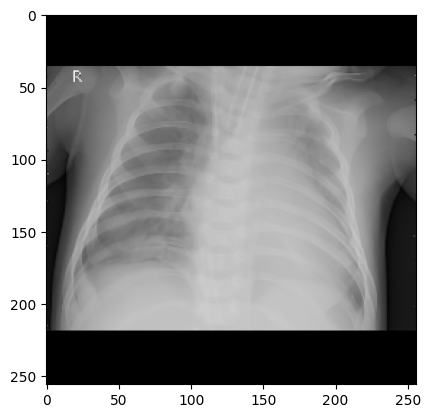

In [ ]:
plt.imshow(img[0].permute(2, 1, 0).cpu().numpy(), cmap="gray")

Hope you have enjoyed this tutorial! Checkout [Mediffusion repository](https://github.com/BardiaKh/Mediffusion) to learn more about what can be done with diffusion models!